In [11]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import sys  
import pickle 

sys.path.append('../Preprocess-Data/')
from category_reducer import category_reducer

from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import load_model

from preprocessor import PreprocessImg
from preprocessor import PreprocessText

In [12]:
def load_data():
    '''
    # Load the data from the csv file and reduce the number of categories
    '''
    data_path = "../Data/news-data-with-imgs.csv"
    data = pd.read_csv(data_path)
    df = data.copy()

    df = category_reducer(df)
    print(df.info())
    df = df[['Content', 'Title', 'img_path']]
    return df

df = load_data()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Title                2 non-null      object
 1   Content              2 non-null      object
 2   Content_url          2 non-null      object
 3   News_type            2 non-null      object
 4   Day_month_year_hour  2 non-null      object
 5   Img_url              2 non-null      object
 6   img_path             2 non-null      object
dtypes: object(7)
memory usage: 240.0+ bytes
None


In [13]:
trained_model = load_model('img2text_model.h5')

loaded_tokenizer = PreprocessText.load_tokenizer('tokenizer.pkl')
img_preprocessor = PreprocessImg()

In [14]:
def generate_text(img_path, trained_model, loaded_tokenizer):
    max_tokens = loaded_tokenizer.max_tokens
    max_caption_length = 100
    
    test_image = img_preprocessor.preprocess_single_img(img_path)

    initial_caption = loaded_tokenizer.start_mark.strip()
    end_caption = loaded_tokenizer.end_mark.strip()

    max_caption_length = 20

    initial_caption_seq = loaded_tokenizer.text_to_token(initial_caption)

    initial_caption_seq = pad_sequences([initial_caption_seq], maxlen=max_tokens)

    final_caption = []

    for i in range(100):
        predictions = trained_model.predict([np.expand_dims(test_image, axis=0), initial_caption_seq])

        predicted_word_index = np.argmax(predictions)

        try:
            predicted_word = loaded_tokenizer.index_word[predicted_word_index]
        except KeyError:
            predicted_word = "<UNKNOWN>"
            pass

        if predicted_word == end_caption:
            break

        final_caption.append(predicted_word)

        initial_caption_seq = pad_sequences([initial_caption_seq[0].tolist() + [predicted_word_index]], maxlen=max_tokens)

    final_caption = ' '.join(final_caption)

    plt.imshow(test_image)
    plt.axis("off")
    plt.show()
    print()
    print("Generated title")
    print(final_caption)

1/1 [==============================] - 0s 80ms/step


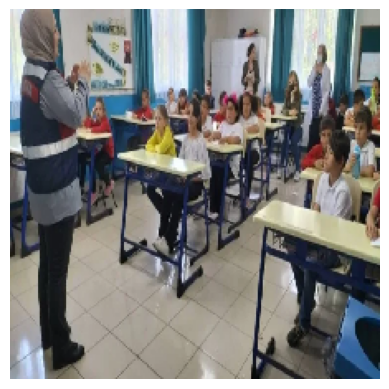


Generated title
çocuklara çocuklara vatandaşlara kades uygulaması tanıtıldı


In [15]:
img_path = "../Data/imgs/" + df['img_path'][0]

generate_text(img_path=img_path, trained_model=trained_model, loaded_tokenizer=loaded_tokenizer)